In [1]:
from agrifoodpy.pipeline import Pipeline
from datablock_setup import datablock_setup
from pipeline_setup import pipeline_setup
import matplotlib.pyplot as plt
import xarray as xr
import copy
import numpy as np
import pandas as pd

In [2]:
sector_emissions_dict = {
    "F-gases":1.60,
    "Waste":5.11,
    "Shipping":0.51,
    "Aviation":22.67,
    "LU sources":20.82, # Sum of 2025 land use sources
    "Agriculture":0, # Set to be calculated by the model
    "Fuel supply":1.57, 
    "Electricity":1.00,
    "Manufacturing":3.57,
    "Buildings":1.11, # Sum of residential and non-residential
    "Transport":1.07,
    "LU sinks":0, # Set to be calculated by the model
    "Removals":0, # Set to be calculated by the model
}


In [3]:
advanced_settings_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vTanjc08kc5vIN-icUMzMEGA9bJuDesLX8V_u2Ab6zSC4MOhLZ8Jrr18DL9o4ofKIrSq6FsJXhPWu3F/pub?gid=0&single=true&output=csv"

def read_advanced_settings():
    """Reads the advanced settings from the spreadsheet URL"""
    advanced_settings  = pd.read_csv(advanced_settings_url, dtype='string')
    advanced_settings_dict = {}

    for index, row in advanced_settings.iterrows():
        if row["type"] == "float": 
            advanced_settings_dict[row["key"]] = float(row["value"])
        elif row["type"] == "string":
            advanced_settings_dict[row["key"]] = str(row["value"])
        elif row["type"] == "bool":
            advanced_settings_dict[row["key"]] = row["value"] == "TRUE"
    
    return advanced_settings_dict

params = read_advanced_settings()

params["yield_proj"] = 0
params["elasticity"] = 0
params["scaling_nutrient"] = "kCal/cap/day"
params["cereal_scaling"] = True
params["bdleaf_conif_ratio"] = 75

params


{'labmeat_co2e': 2.2,
 'dairy_alternatives_co2e': 0.31,
 'rda_kcal': 2250.0,
 'n_scale': 20.0,
 'bdleaf_seq_ha_yr': 1.3,
 'conif_seq_ha_yr': 11.2,
 'peatland_seq_ha_yr': 20.0,
 'managed_arable_seq_ha_yr': 2.0,
 'managed_pasture_seq_ha_yr': 2.0,
 'mixed_farming_seq_ha_yr': 2.0,
 'beccs_crops_seq_ha_yr': 23.5,
 'dairy_herd_grazing': 0.05,
 'dairy_herd_beef': 0.52,
 'horticulture_land_ratio': 0.086,
 'pulse_land_ratio': 0.033,
 'mixed_farming_production_scale': 0.93,
 'mixed_farming_secondary_production_scale': 0.9,
 'agroecology_tree_coverage': 0.1,
 'nitrogen_prod_factor': 0.0,
 'nitrogen_ghg_factor': 0.1,
 'manure_prod_factor': 0.0,
 'manure_ghg_factor': 0.07,
 'breeding_prod_factor': 0.0,
 'breeding_ghg_factor': 0.08,
 'methane_prod_factor': 0.0,
 'methane_ghg_factor': 0.13,
 'fossil_livestock_prod_factor': 0.0,
 'fossil_livestock_ghg_factor': 0.1,
 'fossil_arable_prod_factor': 0.0,
 'fossil_arable_ghg_factor': 0.1,
 'scaling_nutrient': 'kCal/cap/day',
 'emission_factors': 'NDC 2020',

In [4]:
# Set the datablock
datablock_init = datablock_setup()


In [5]:
# Set the pipeline and run it

def SSR_emissions(input_datablock, params):

    datablock_copy = copy.deepcopy(input_datablock)
    food_system = Pipeline(datablock_copy)

    # SSR
    food_system = pipeline_setup(food_system, params)
    food_system.run()
    datablock_result = food_system.datablock

    metric_yr = 2050
    gcapday = datablock_result["food"]["g/cap/day"].sel(Year=metric_yr).fillna(0)
    SSR_metric_yr = gcapday.fbs.SSR()


    # Emissions
    seq_da = datablock_result["impact"]["co2e_sequestration"].sel(Year=metric_yr)
    emissions = datablock_result["impact"]["g_co2e/year"]["production"].sel(Year=metric_yr)/1e6
    total_emissions = emissions.sum(dim="Item").values/1e6
    total_seq = seq_da.sel(Item=["Broadleaf woodland",
                                    "Coniferous woodland",
                                    "Managed pasture",
                                    "Managed arable",
                                    "Mixed farming",
                                    "Silvopasture",
                                    "Agroforestry"]).sum(dim="Item").values/1e6

    total_removals = seq_da.sel(Item=["BECCS from waste", "BECCS from overseas biomass", "BECCS from land", "DACCS"]).sum(dim="Item").values/1e6

    emissions_balance = xr.DataArray(data = list(sector_emissions_dict.values()),
                            name="Sectoral emissions",
                            coords={"Sector": list(sector_emissions_dict.keys())})

    emissions_balance.loc[{"Sector": "Agriculture"}] = total_emissions
    emissions_balance.loc[{"Sector": "LU sinks"}] = -total_seq
    emissions_balance.loc[{"Sector": "Removals"}] = -total_removals

    emissions_balance.loc[{"Sector": "LU sources"}] -= seq_da.sel(Item=["Restored upland peat", "Restored lowland peat"]).sum(dim="Item").values/1e6

    total_emissions = emissions_balance.sum()

    return SSR_metric_yr.to_numpy(), total_emissions.to_numpy()


In [6]:
# Set the runtime parameters

params["ruminant"] = 0
params["pig_poultry"] = 0
params["fish_seafood"] = 0
params["dairy"] = 0
params["eggs"] = 0
params["fruit_veg"] = 0
params["pulses"] = 0
params["meat_alternatives"] = 0
params["dairy_alternatives"] = 0
params["waste"] = 0
params["foresting_pasture"] = 13.17
params["land_BECCS"] = 0
params["horticulture"] = 0
params["pulse_production"] = 0
params["lowland_peatland"] = 0
params["upland_peatland"] = 0
params["pasture_soil_carbon"] = 0
params["arable_soil_carbon"] = 0
params["mixed_farming"] = 0
params["silvopasture"] = 0
params["nitrogen"] = 0
params["methane_inhibitor"] = 0
params["stock_density"] = 0
params["manure_management"] = 0
params["animal_breeding"] = 0
params["fossil_livestock"] = 0
params["agroforestry"] = 0
params["vertical_farming"] = 0
params["fossil_arable"] = 0
params["waste_BECCS"] = 0
params["overseas_BECCS"] = 0
params["DACCS"] = 0

In [ ]:
SSR_results = np.empty((10,10))
emissions_results = np.empty((10,10))

for irm, rm in enumerate(np.linspace(0, 100, 10)):

    params["ruminant"] = rm

    for isd, sd in enumerate(np.linspace(-50, 50, 10)):
        params["stock_density"] = sd

        SSR_results[irm, isd], emissions_results[irm, isd] = SSR_emissions(datablock_init, params)

Text(0, 0.5, 'Ruminant')

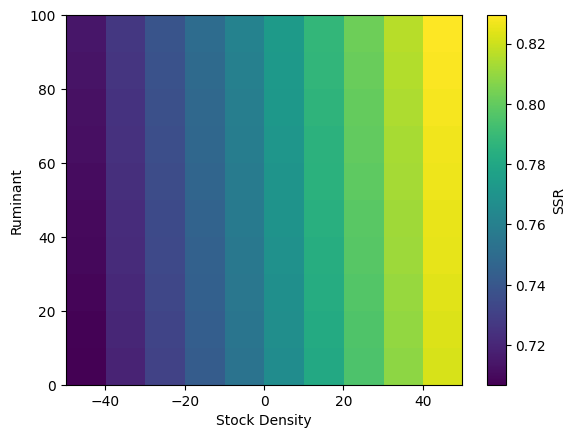

In [15]:
plt.imshow(SSR_results, cmap='viridis', interpolation='nearest', extent=[-50, 50, 0, 100], aspect='auto')
plt.colorbar(label='SSR')
plt.xlabel('Stock Density')
plt.ylabel('Ruminant')

Text(0, 0.5, 'Ruminant')

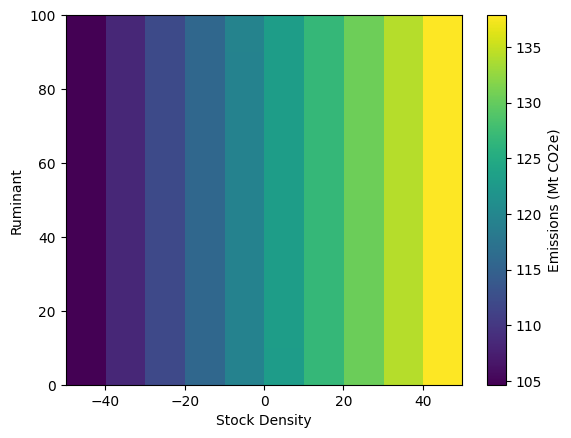

In [16]:
plt.imshow(emissions_results, cmap='viridis', interpolation='nearest', extent=[-50, 50, 0, 100], aspect='auto')
plt.colorbar(label='Emissions (Mt CO2e)')
plt.xlabel('Stock Density')
plt.ylabel('Ruminant')